In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from random import randint
from torchvision.transforms.functional import rgb_to_grayscale
import numpy as np
import shared.data_utils as data_utils


class ImageToMeshDataset(Dataset):
    def __init__(self, dataset_dir):
        self.dataset_dir = dataset_dir
        files = next(os.walk(dataset_dir))[1]

        self.len = len(files)
        self.n_variations = len(os.listdir(os.path.join(dataset_dir, files[0]))) - 2 # ignore processed_model.pt and make it zero indexed

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        mesh_dict = torch.load(os.path.join(self.dataset_dir, f"model_{idx}", "processed_model.pt"))

        
        # Single image for resnet
        img_idx = 0
        img = read_image(os.path.join(self.dataset_dir, f"model_{idx}", f"var_{img_idx}.png"))
        mask = data_utils.background_mask(img)
        mesh_dict['image'] = rgb_to_grayscale(img[0:3]) * mask # ignore alpha channel

        return mesh_dict

    def map(self, func):
        for idx in range(self.len):
            path = os.path.join(self.dataset_dir, f"model_{idx}", "processed_model.pt")
            mesh_dict = func(torch.load(path))
            torch.save(mesh_dict, path)
        return self
        
def pad_batch(batch):
    # group matching keys in batch
    items = list(zip(*[item.values() for item in batch]))
    packed_dict = {}
    for i, key in enumerate(batch[0].keys()):
        if items[i][0].dim() == 0:
            padded_values = torch.tensor(items[i]).contiguous()
        else:
            padded_values = torch.nn.utils.rnn.pad_sequence(items[i], batch_first=True, padding_value=0.).contiguous()
    
        packed_dict[key] = padded_values
    return packed_dict

if __name__ == "__main__":
    import shared.data_utils as data_utils
    import modules
    from contextlib import nullcontext
    import torch._inductor.codecache
    from torch.utils.data import DataLoader
    from json import load

    random_seed = 21
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
    torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
    batch_size = 4
    shuffle = True
    num_workers = 4
    compile = True 
    dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
    device_type = 'cuda'
    device = torch.device(device_type)
    ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
    ctx = nullcontext() if device_type == 'cpu' else torch.autocast(device_type=device_type, dtype=ptdtype)

    print(f"Using {device_type} device")
    torch.multiprocessing.set_start_method('spawn')

    def cycle(iterable):
        # cycle through a dataloader indefinitely
        while True:
            for x in iterable:
                yield x

    dataset_path = "./processed_meshes/"
    synthetic_dataset = ImageToMeshDataset(dataset_path)

    # Create vertex and face datasets
    is_preprocessed = 'faces_mask' in synthetic_dataset[0].keys() and 'num_vertices' in synthetic_dataset[0].keys()
    if is_preprocessed:
        dataset = synthetic_dataset
    else:
        # Dataset has already been processed for vertex and face model training
        dataset = data_utils.make_vertex_model_dataset(
            synthetic_dataset, apply_random_shift=False)
        dataset = data_utils.make_face_model_dataset(
            synthetic_dataset, apply_random_shift=False)


    num_examples = len(synthetic_dataset)
    train_idxs, val_idxs = torch.utils.data.random_split(range(num_examples), [0.95, 0.05])

    train_v_ds = torch.utils.data.Subset(dataset, train_idxs)
    val_v_ds = torch.utils.data.Subset(dataset, val_idxs)

    vertex_train_loader = iter(cycle(DataLoader(train_v_ds, 
                                            shuffle=shuffle, 
                                            batch_size=batch_size, 
                                            collate_fn=pad_batch,
                                            pin_memory=True,
                                            drop_last=True)))

    vertex_val_loader = iter(cycle(DataLoader(val_v_ds, 
                                            shuffle=shuffle, 
                                            batch_size=batch_size, 
                                            collate_fn=pad_batch,
                                            num_workers=0,
                                            pin_memory=True)))

Using cuda device
[341253, 272048, 27857, 300601, 67184, 358509, 264803, 53078, 98821, 205979]
[207662, 346868, 288247, 339322, 241594, 324323, 238951, 230822, 129937, 334003]


In [3]:

# Create vertex model
config = torch.load('path/to/config.pt') # model config
quantization_bits = 8

class_labels = {'bench': 0, 'chair': 1, 'table': 2}

# Create vertex model
vertex_model = modules.ImageToVertexModel(
    decoder_config=config["vertex_decoder_config"],
    res_net_config=config["res_net_config"],
    max_num_input_verts=config["max_num_input_verts"],
    quantization_bits=quantization_bits,
    class_conditional=True,
    num_classes=len(class_labels),
    device=device
).to(device=device)

# Create face model
face_model = modules.FaceModel(
    encoder_config=config["face_encoder_config"],
    decoder_config=config["face_decoder_config"],
    class_conditional=False,
    max_seq_length=config["max_num_face_sequence"],
    quantization_bits=quantization_bits,
    max_num_input_verts=config["max_num_input_verts"],
    decoder_cross_attention=True,
    use_discrete_vertex_embeddings=True,
    device=device
).to(device=device)

# compile the model

if compile:
    # requires PyTorch 2.0 and Linux
    print("compiling the model... (takes a ~minute)")
    vertex_model = torch.compile(vertex_model, dynamic=True)
    face_model = torch.compile(face_model, dynamic=True)

n_samples = 4

scaler = torch.cuda.amp.GradScaler(enabled=device_type == 'cuda')

chkpt = torch.load('path/to/ckpt.pt')
vertex_model.load_state_dict(chkpt['vertex_model'])
face_model.load_state_dict(chkpt['face_model'])
chkpt = None
max_num_input_verts = config['max_num_input_verts']
max_num_face_sequence = config['max_num_face_sequence']

{'init_vertex_learning_rate': 0.0003, 'init_face_learning_rate': 0.0001, 'vertex_decoder_config': {'embd_size': 256, 'fc_size': 1024, 'num_layers': 14, 'num_heads': 8, 'dropout_rate': 0.2, 'take_context_embedding': True}, 'res_net_config': {'hidden_sizes': [64, 128, 256], 'dropout_rate': 0.2, 'num_blocks': [1, 2, 2], 're_zero': True, 'kernel_size': [3, 3], 'bias': False}, 'face_encoder_config': {'embd_size': 256, 'fc_size': 1024, 'num_layers': 8, 'num_heads': 8, 'dropout_rate': 0.2}, 'face_decoder_config': {'embd_size': 256, 'fc_size': 1024, 'num_layers': 8, 'num_heads': 8, 'dropout_rate': 0.2, 'take_context_embedding': True}, 'max_num_input_verts': 550, 'max_num_face_sequence': 1200}
compiling the model... (takes a ~minute)


In [22]:
vertex_val_batch = next(vertex_val_loader)
for key, value in vertex_val_batch.items():            
    vertex_val_batch[key] = value.to(device)

In [23]:
with ctx:
    vertex_samples = vertex_model.sample(
    n_samples, context=vertex_val_batch, max_sample_length=max_num_input_verts, top_p=0.6,
    recenter_verts=False, only_return_complete=False)

    face_samples = face_model.sample(
    context=vertex_samples, max_sample_length=max_num_face_sequence, top_p=0.6,
    only_return_complete=False) 

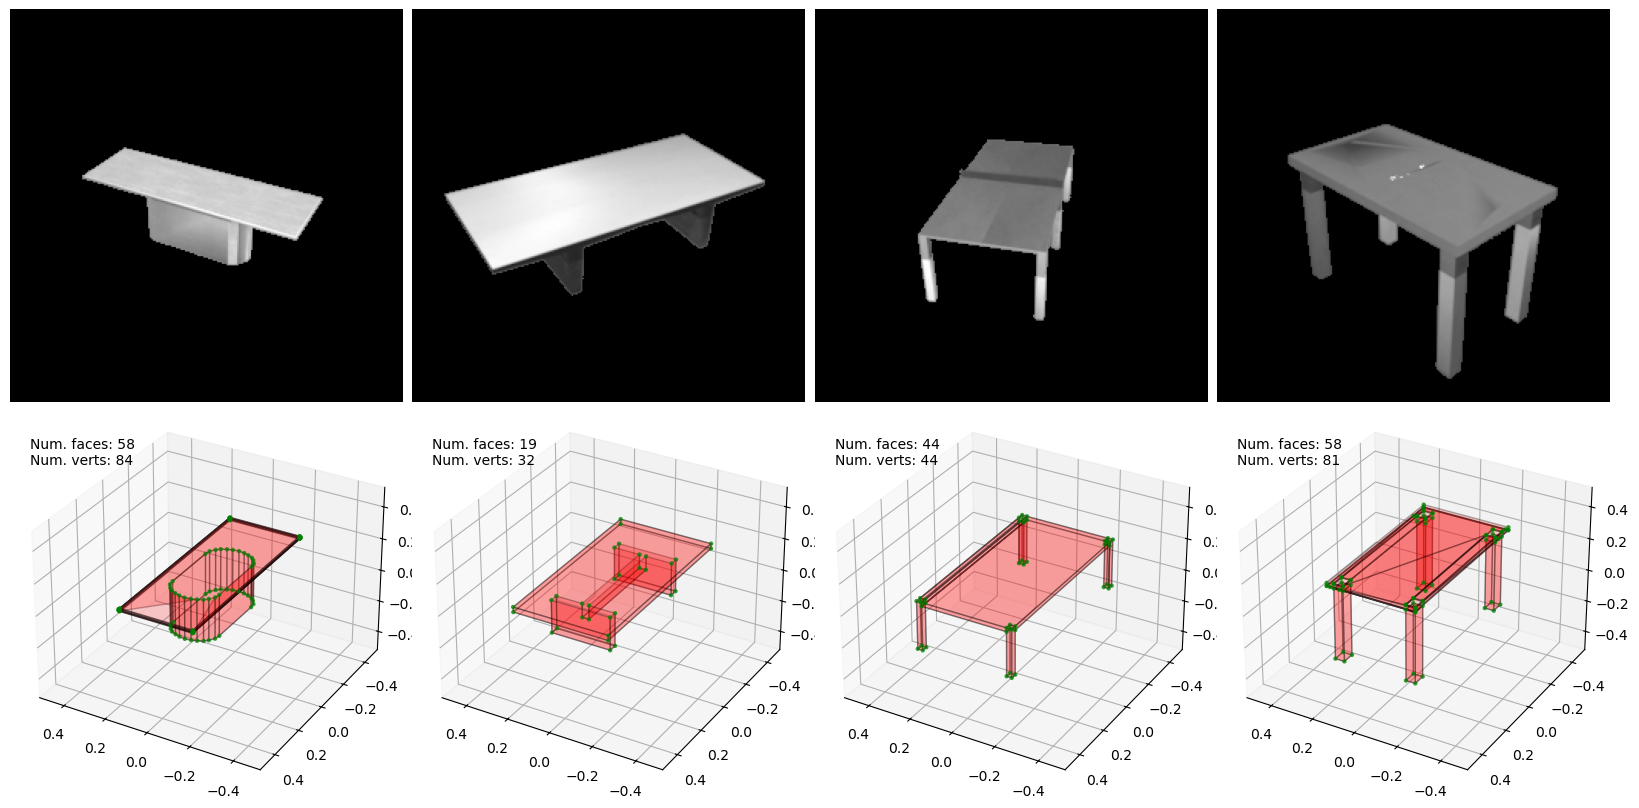

In [24]:
mesh_list = []
for batch in range(min(n_samples, batch_size)):
    mesh_list.append(
        {
        'vertices': vertex_samples['vertices'][batch][:vertex_samples['num_vertices'][batch]].cpu(),
        'faces': data_utils.unflatten_faces(
            face_samples['faces'][batch][:face_samples['num_face_indices'][batch]].cpu())
        }
    )


fig = data_utils.plot_meshes(mesh_list, ax_lims=0.5, return_fig=True) #, 0, projection='3d')
fig_size = 4

n_rows = 1
scale = 1.0
fig_adjusted_height = fig_size * (n_rows + scale)  # Increase the height slightly more for larger images
fig.set_figheight(fig_adjusted_height)

# Adjust positions of existing mesh axes to make space for larger images
for ax in fig.axes:
    pos = ax.get_position()
    # Adjust the bottom position more significantly to make space for larger images
    new_bottom = pos.y0 - (scale / n_rows)  # Increase the offset for the bottom position
    new_bottom = max(new_bottom, 0)
    # Optionally adjust the height of the mesh plots if needed
    #new_height = pos.height * 0.85  # Adjust based on your needs
    ax.set_position([pos.x0, new_bottom, pos.width, pos.height])

# Now add your image axes above the mesh plots
for batch in range(min(n_samples, batch_size)):
    # Calculate position for the new image axes
    mesh_ax = fig.axes[batch]
    mesh_pos = mesh_ax.get_position()

    image_height = mesh_pos.height #* 1.2  # Adjust this multiplier based on desired image size
    image_bottom = mesh_pos.y0 + mesh_pos.height - (image_height - mesh_pos.height)
    image_pos = [mesh_pos.x0, mesh_pos.y0 + mesh_pos.height, mesh_pos.width, mesh_pos.height / n_rows]
    
    # Create new axes for the image
    axins = fig.add_axes(image_pos)
    image = vertex_val_batch['image'][batch].clone() 
    if vertex_val_batch['image'][batch].shape[0] == 3:
        cmap=None
    else:
        cmap='gray'
    axins.imshow(image.permute(1,2,0).cpu(), cmap='gray')
    axins.axis('off')
